In [3]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import subprocess
from tqdm import tqdm
from glob import glob

In [4]:
category_order = ["inversion", "translocation", "duplication", "indel (>=50bp)", "syntenic_region", "not_aligned"]
category_order_v2 = ["Inversions", "Translocations", "Duplications", "Indels (>=50bp)", "Syntenic regions", "Not aligned"]
chr_natural_order = [f"chr{n}{hap}" for n in range(1, 19) for hap in ["A", "B"]]

In [97]:
def run_shell(command):
    subprocess.run(command, shell=True)

def calculate_feature_coverage_at_sv(feature_bed, sv_coords_bed):
    """
    reads in a TE bed that has four columns: chr, start, end, matched consensus TE.
    then calculate TE coverage by order or COS.
    """
    # read in TE bed
    df = pd.read_csv(feature_bed, sep="\t", header=None, usecols=(0,1,2))
    df.columns = ["chr", "start", "end"]
    df[["start", "end"]] = df[["start", "end"]].astype(int)
    df["feat_len"] = df["end"]-df["start"]
    # # get feature bed for length to compute coverage in feature region
    sv = pd.read_csv(sv_coords_bed, sep="\t", header=None, usecols=(0,1,2))
    sv.columns = ["chr", "start", "end"]
    sv["sv_len"] = sv["end"]-sv["start"]
    # # if more than one region per chr take their sum, e.g. sum lengths of noncentromere regions flanking centromere.
    sv = sv.groupby("chr")["sv_len"].sum().reset_index()
    df = pd.merge(df, sv[["chr", "sv_len"]], on="chr")
    df = df.groupby(["chr", "sv_len"])["feat_len"].sum().reset_index()
    df["coverage"] = (df["feat_len"] / df["sv_len"]) * 100
    return df

def calculate_feat_coverage_diff(SV_feat_cov_df, nonSV_feat_cov_df):
    """
    calculates feature coverage difference by (SV - nonSV).
    """
    result = pd.merge(SV_feat_cov_df, nonSV_feat_cov_df, \
                      on=["chr"], suffixes=["_SV", "_nonSV"])
    result = result[["chr", "coverage_SV", "coverage_nonSV"]]
    result["coverage_diff"] = result["coverage_SV"]-result["coverage_nonSV"]
    return result

In [98]:
!cat SV_hapA.bed SV_hapB.bed > SV.bed
!bedtools subtract -a /media/ssd/rita/project/104e/SV_calling/l200b500c500/TE_enrichment/v3.9.chr.haplotype-paired.fasta.bed -b SV.bed > nonSV.bed
# !sort -k1,1 -k2,2n TE_enrichment/TE.bed | bedtools merge > TE_enrichment/TE.merged.bed
# mv TE.merged.bed TE.bed

# intersect TEs with SVs to generate SV TEs bed file. TE only counted in if overlapped >=70%.
!bedtools intersect -f 0.7 -a TE_enrichment/TE.bed -b SV.bed -wo > TE_enrichment/SV_TE.bed
!bedtools intersect -f 0.7 -a TE_enrichment/TE.bed -b nonSV.bed -wo > TE_enrichment/nonSV_TE.bed

/tmp/ipykernel_3182446/2132976277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["inside SV", "outside SV"])


Text(0.5, 0, '')

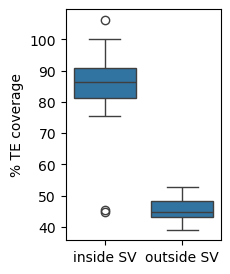

In [99]:
# generate observed result for actual data
observed_TE_coverage_at_SV = calculate_feature_coverage_at_sv("TE_enrichment/SV_TE.bed", "SV.bed")
observed_TE_coverage_at_nonSV = calculate_feature_coverage_at_sv("TE_enrichment/nonSV_TE.bed", "nonSV.bed")
observed_result = calculate_feat_coverage_diff(observed_TE_coverage_at_SV, observed_TE_coverage_at_nonSV)
observed_result["chr"] = pd.Categorical(observed_result["chr"], categories=chr_natural_order, ordered=True) 
observed_result = observed_result.sort_values("chr")
observed_result_plot = pd.melt(observed_result, id_vars="chr", value_vars=["coverage_SV", "coverage_nonSV"])
observed_result_plot.columns = ["chr", "variable", "% TE coverage"]
plt.figure(figsize=(2, 3))
ax = sns.boxplot(observed_result_plot, y="% TE coverage", x="variable")
ax.set_xticklabels(["inside SV", "outside SV"])
ax.set_xlabel("")

In [100]:
!grep -P "\tgene\t" /media/ssd/rita/project/104e/gene_annotations/Puccinia_striiformis_Pst104E.gff3 | cut -f1,4,5 | awk '{print $1 "\t" $2-1 "\t" $3}' > gene_enrichment/gene.bed
!sort -k1,1 -k2,2n gene_enrichment/gene.bed | bedtools merge > gene_enrichment/gene.merged.bed
!bedtools intersect -f 0.7 -a gene_enrichment/gene.merged.bed -b SV.bed > gene_enrichment/SV_gene.bed
!bedtools intersect -f 0.7 -a gene_enrichment/gene.merged.bed -b nonSV.bed > gene_enrichment/nonSV_gene.bed

/tmp/ipykernel_3182446/1028340442.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["inside SV", "outside SV"])


Text(0.5, 0, '')

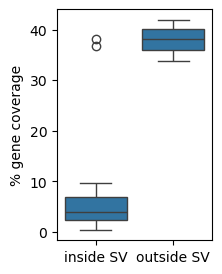

In [101]:
# generate observed result for actual data
observed_gene_coverage_at_SV = calculate_feature_coverage_at_sv("gene_enrichment/SV_gene.bed", "SV.bed")
observed_gene_coverage_at_nonSV = calculate_feature_coverage_at_sv("gene_enrichment/nonSV_gene.bed", "nonSV.bed")
observed_result = calculate_feat_coverage_diff(observed_gene_coverage_at_SV, observed_gene_coverage_at_nonSV)
observed_result["chr"] = pd.Categorical(observed_result["chr"], categories=chr_natural_order, ordered=True) 
observed_result = observed_result.sort_values("chr")
observed_result_plot = pd.melt(observed_result, id_vars="chr", value_vars=["coverage_SV", "coverage_nonSV"])
observed_result_plot.columns = ["chr", "variable", "% gene coverage"]
plt.figure(figsize=(2, 3))
ax = sns.boxplot(observed_result_plot, y="% gene coverage", x="variable")
ax.set_xticklabels(["inside SV", "outside SV"])
ax.set_xlabel("")